In [10]:
import sqlalchemy
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

url_object = sqlalchemy.engine.URL.create(
    "postgresql+psycopg2",
    username="pguser",
    password="pgpass",
    host="localhost",
    database="finance_dwh",
    port=5431
)

engine = sqlalchemy.create_engine(
    url_object)
query_str = """select * from lng_consumption_temperature_daily_models"""
combined_df = pd.read_sql_query(query_str, con=engine)
combined_df['day'] = pd.to_datetime(combined_df['day'])

In [11]:


query_str = """select 
country,
day,
sum(average_temperature * city_population) / sum(city_population) average_temperature
from 
country_weather_forecasts 
 group by country, day
"""
forecasts = pd.read_sql_query(query_str, con=engine).to_dict('records')


{'day': '2023-11-06', 'country': 'BE', 'consumption': 40.596826566345605, 'historic_consumption': 44.54}
{'day': '2023-11-06', 'country': 'BG', 'consumption': 27.81272765910272, 'historic_consumption': 7.400333333333333}
{'day': '2023-11-06', 'country': 'CY', 'consumption': 0.0, 'historic_consumption': 0.0}
{'day': '2023-11-06', 'country': 'ES', 'consumption': 81.8346, 'historic_consumption': 81.8346}
{'day': '2023-11-06', 'country': 'FI', 'consumption': 1.756296531789094, 'historic_consumption': 2.629833333333333}
{'day': '2023-11-06', 'country': 'FR', 'consumption': 116.12292840490763, 'historic_consumption': 117.9419}
{'day': '2023-11-06', 'country': 'HR', 'consumption': 6.347847141005841, 'historic_consumption': 7.83}
{'day': '2023-11-06', 'country': 'HU', 'consumption': 22.132346740069174, 'historic_consumption': 30.48936666666667}
{'day': '2023-11-06', 'country': 'IT', 'consumption': 145.35172345802886, 'historic_consumption': 185.93333333333334}
{'day': '2023-11-06', 'country': 

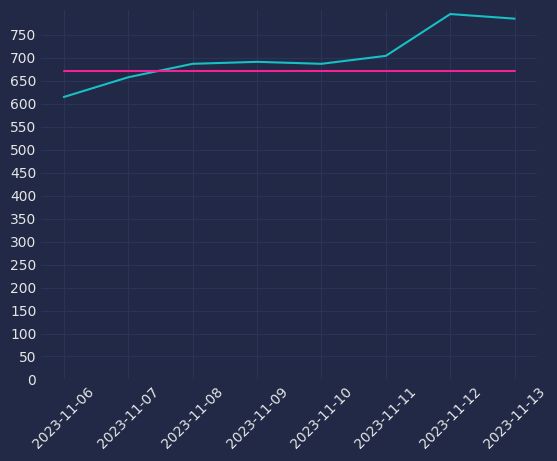

In [13]:
def calculate_expected_gas_consumption(current_temperature, average_temperature, average_gas_consumption, a_coefficient):
    # Calculate the Heating Degree Days (HDD)
    hdd = average_temperature - current_temperature
    
    # Calculate the expected gas consumption
    expected_gas_consumption = average_gas_consumption + (hdd * a_coefficient)
    
    return expected_gas_consumption

import matplotlib.pyplot as plt
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
from datetime import date as dt, timedelta
dates = [(dt.today() + timedelta(x)) for x in range(1,9)]
data = []
for day in dates:
    country_stats = combined_df[combined_df['day'] == day.strftime('2022-%m-13')].to_dict('records')
    for country in country_stats:
        expected_temperature = [x['average_temperature'] for x in forecasts 
            if x['day'].strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d') and x['country'] == country['country']][0]
        expected_consumption = calculate_expected_gas_consumption(
            expected_temperature, country['average_temperature_day'], country['amount'], country['a_coefficient'])
        row = {
            'day': day.strftime('%Y-%m-%d'),
            'country': country['country'],
            'consumption': expected_consumption,
            'historic_consumption': country['amount']
            
        }
        data.append(row)

df = pd.DataFrame(data)
sum_df = df.groupby(['day'], as_index=False).agg({'consumption': 'sum', 'historic_consumption': 'sum'})

from io import BytesIO
import discord
import requests

url = 'https://discord.com/api/webhooks/discordchannel/discordkey'

session = requests.Session()
webhook = discord.webhook.SyncWebhook.from_url(
    url, session=session)
plt.xticks(rotation = 45)
plt.plot(sum_df['day'], sum_df['consumption'])
plt.plot(sum_df['day'], sum_df['historic_consumption'])
plt.yticks(np.arange(min(0, min(sum_df['consumption'])), max(0, max(sum_df['consumption'])), 50))


with BytesIO() as image_binary:
    plt.savefig(image_binary, format='png')
    image_binary.seek(0)
    file = discord.File(fp=image_binary, filename='test.png')
    webhook.send('Example Content', file=file)